# FORECASTING USING MOVING AVERAGE MODEL

_**Consider appropriate time-series dataset and forecast using a moving average model.**_

In [9]:
# Imports packages

import numpy as np
import pandas as pd
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_absolute_error, mean_squared_error, root_mean_squared_error
import matplotlib.pyplot as plt
from matplotlib.dates import MonthLocator, AutoDateLocator

### Retrieving & Analyzing the Data

The dataset contains the volume of widget sales for over 500 days starting on January 1, 2019 for a fictitous company. The volume of sales is expressed in thousands of US dollars.

In [11]:
# Loads the dataset
sales = pd.read_csv("../Data/time-series/widget_sales.csv")

# Shows few instances from top
display(sales.head())

,date,widget_sales
0,2019-01-01,50.496714
1,2019-01-02,50.805493
2,2019-01-03,51.477758
3,2019-01-04,53.542228
4,2019-01-05,54.873108


In [12]:
# Shows few instances from bottom
display(sales.tail())

,date,widget_sales
495,2020-05-10,64.087371
496,2020-05-11,63.992081
497,2020-05-12,63.029894
498,2020-05-13,61.671797
499,2020-05-14,59.443839


In [13]:
# Checks the shape of the dataset
print(sales.shape)

(500, 2)


In [14]:
# Checks the descriptive statistics of the dataset
print(sales.describe())

       widget_sales
count    500.000000
mean      46.969858
std       15.382473
min       20.674946
25%       32.507149
50%       47.667536
75%       59.425693
max       82.922496


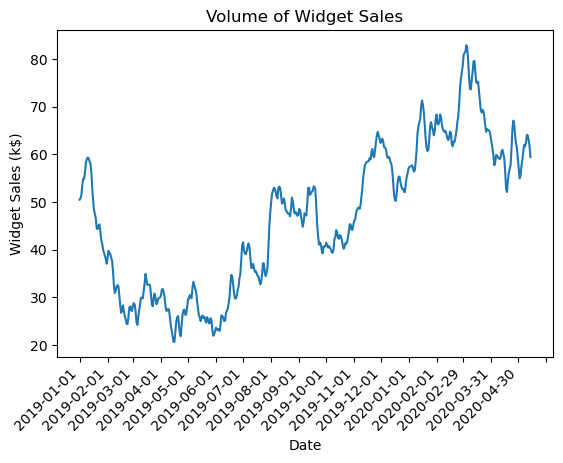

In [15]:
fig, ax = plt.subplots()
ax.plot(sales['date'], sales['widget_sales']) 
ax.set_xlabel('Date')
ax.set_ylabel('Widget Sales (k$)') 
ax.xaxis.set_major_locator(MonthLocator())
#ax.xaxis.set_major_formatter(DateFormatter('%Y-%m-%d'))
ax.set_title("Volume of Widget Sales")
fig.autofmt_xdate(rotation=45)
plt.show()

The forecasting period is illustrated by the gray zone in above figure.

**Below ones are the findings out of the above figure.**
1. It shows long-term trend with peaks and troughs along with way and hence it is not a stationary time-series.
2. There is no apparent cyclical pattern in the data and hence the effect on seasonality on the forecasting can be ruled out.

In [18]:
# Checks for stationarity using augmented Dickey-Fuller test

sales_adf_results = adfuller(sales["widget_sales"])

print(f"ADF Statistic: {sales_adf_results[0].round(2)}")
print(f"p-Value: {sales_adf_results[1].round(2)}")

ADF Statistic: -1.51
p-Value: 0.53


As the ADF statistic is not a large negative number, and the p-value is greater than 0.05, the time-series is not stationary, and transformations is required to be applied to make it stationary.

In [20]:
# First order differencing is applied to make the series stationary
sales_diff = np.diff(sales["widget_sales"], n=1)

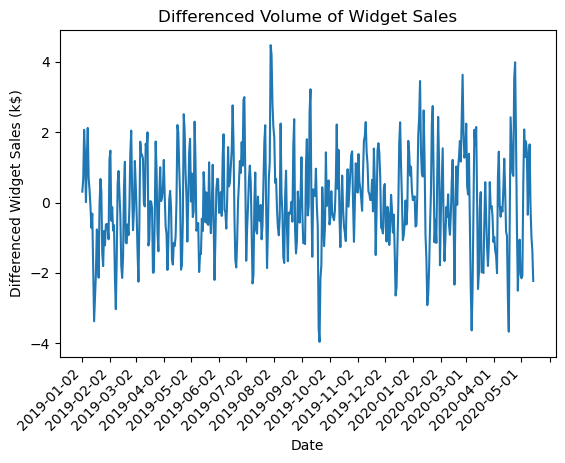

In [21]:
# Plots the differenced series to check if trend component is removed

fig, ax = plt.subplots()
ax.plot(sales['date'][1:], sales_diff) 
ax.set_xlabel('Date')
ax.set_ylabel('Differenced Widget Sales (k$)') 
ax.xaxis.set_major_locator(MonthLocator())
#ax.xaxis.set_major_formatter(DateFormatter('%Y-%m-%d'))
ax.set_title("Differenced Volume of Widget Sales")
fig.autofmt_xdate(rotation=45)
plt.show()


In [22]:
# Stationarity is once again tested using the ADF test

sales_diff_adf_results = adfuller(sales_diff)

print(f"ADF Statistic: {sales_diff_adf_results[0].round(2)}")
print(f"p-Value: {sales_diff_adf_results[1].round(2)}")

ADF Statistic: -10.58
p-Value: 0.0


With a large negative ADF statistic and a p-value much smaller than 0.05, differenced series is considered to be stationary.

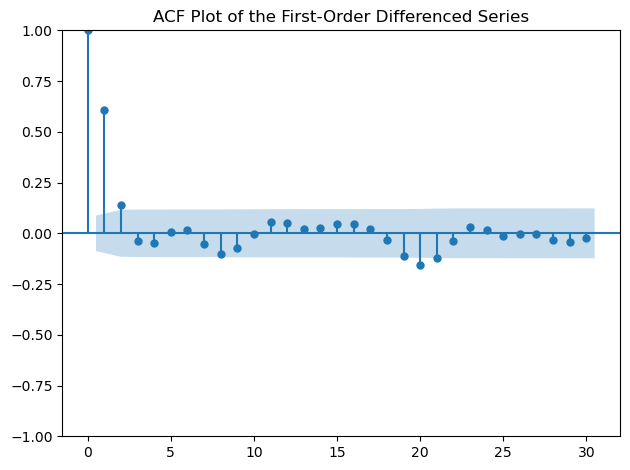

In [24]:
# Plots the ACF of the differenced series

plot_acf(sales_diff, lags=30, title="ACF Plot of the First-Order Differenced Series")
plt.tight_layout()

Followings points were noted out of the above plot.
1. There are significant correlation coefficient up until lag 2 and thereafter the coefficients remained non-significant as shown in the shaded region.
2. It indicates that there is a stationary moving average process of order 2 or MA(2) to forecast the stationary time-series.
3. There are some significant coefficients around lag 20, but this could just due to chance because there are non-significant ones between lag 3 and after lag 20.

### Preparing Datasets

In [27]:
# Stores the sales differences with respect to date into a container
sales_diff_df = pd.DataFrame({"date": sales['date'][1:], "sales_diff": sales_diff})

display(sales_diff_df)

,date,sales_diff
1,2019-01-02,0.308778
2,2019-01-03,0.672265
3,2019-01-04,2.064470
4,2019-01-05,1.330880
5,2019-01-06,0.012034
...,...,...
495,2020-05-10,1.651336
496,2020-05-11,-0.095290
497,2020-05-12,-0.962187
498,2020-05-13,-1.358097


Allocates 90% [449 instances] of the data to the train set and reserve the other 10% [50 instances] for the test set.

In [29]:
X_train = sales_diff_df[:-50]
X_test = sales_diff_df[-50:]

In [30]:
# Prints last and first few timesteps from the train and testset, respectivley, to note the timestep indexes.

display(X_train.tail())

,date,sales_diff
445,2020-03-21,-0.531086
446,2020-03-22,0.577963
447,2020-03-23,-0.409040
448,2020-03-24,-1.249779
449,2020-03-25,-1.803658


In [31]:
display(X_test.head())

,date,sales_diff
450,2020-03-26,-1.170131
451,2020-03-27,0.580967
452,2020-03-28,-0.144902
453,2020-03-29,-0.096564
454,2020-03-30,-0.372334


In [32]:
# Also the shape of the train and testset are shown to note the length of train and testset. 
# First dimension of the trainset shape indicate the length of the horizon.

print(X_train.shape)

(449, 2)


In [33]:
print(X_test.shape)

(50, 2)


In [34]:
# Sets the length (timelines) of the train and testset to be used later

train_len = X_train.shape[0]
test_len = X_test.shape[0]

### Forecasting using Moving Average Process

Forecasting will first be done using naive forecasting techniques as baselines and then using second-order moving average to check if the latter one can outperform the baseline performance.

As MA(_q_) model does not allow us to forecast all timesteps steps (beyond _q_) into the future in one shot, they must therefore be recursively estimated. The following function will predict two timesteps or less at a time, until 50 predictions are made, values of the test set. This method is called rolling forecasts.


In [38]:
def rolling_forecast(data, train_len, horizon, window, method):
    """
        Forecasts for timesteps of length 'window' or less at a time, until all 
        forecasts of length 'horizon' are made
    """    
    
    total_len = train_len + horizon

    if method == "mean":
        prediction_mean = []
        
        for i in range(train_len, total_len, window):
            mean = np.mean(data[:i].values)
            prediction_mean.extend(mean for _ in range(window))

        return prediction_mean

    elif method == "last":
        prediction_last_value = []
        
        for i in range(train_len, total_len, window):
            #last_value = data[:i].iloc[-1].values[0]
            last_value = data[:i].iloc[-1]
            prediction_last_value.extend(last_value for _ in range(window))    

        return prediction_last_value

    elif method == "MA":
        prediction_MA = []

        for i in range(train_len, total_len, window):
            model = SARIMAX(data[:i], order=(0, 0, 2))
            result = model.fit(disp=False)
            predictions = result.get_prediction(0, i + window - 1)
            oos_predictions = predictions.predicted_mean.iloc[-window:]
            prediction_MA.extend(oos_predictions)

        return prediction_MA


In [39]:
# Creates a container to hold all the differenced forecasts for each method
predictions_diff = X_test.copy()

In [40]:
# Generates differenced forecasts for each method

predictions_diff["prediction_mean"] = rolling_forecast(sales_diff_df["sales_diff"], train_len, test_len, 2, "mean")
predictions_diff["prediction_last_value"] = rolling_forecast(sales_diff_df["sales_diff"], train_len, test_len, 2, "last")
predictions_diff["prediction_MA"] = rolling_forecast(sales_diff_df["sales_diff"], train_len, test_len, 2, "MA")

In [41]:
# Prints forecasts for first few timesteps from all the used methods
display(predictions_diff.head())

,date,sales_diff,prediction_mean,prediction_last_value,prediction_MA
450,2020-03-26,-1.170131,0.034319,-1.803658,-1.078833
451,2020-03-27,0.580967,0.034319,-1.803658,-0.273309
452,2020-03-28,-0.144902,0.032861,0.580967,0.781223
453,2020-03-29,-0.096564,0.032861,0.580967,0.234969
454,2020-03-30,-0.372334,0.032183,-0.096564,0.168994


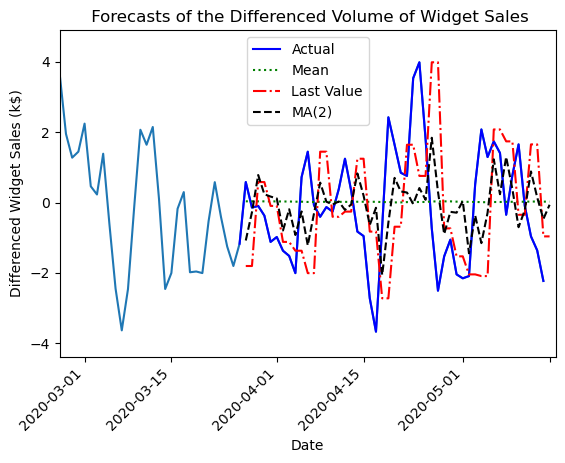

In [42]:
# Visualizes the differenced forecasting of all the used methods over actual differenced target

fig, ax = plt.subplots()
ax.plot(sales_diff_df['date'], sales_diff_df['sales_diff']) 
ax.plot(predictions_diff['date'], predictions_diff['sales_diff'], "b-", label="Actual") 
ax.plot(predictions_diff["prediction_mean"], "g:", label="Mean")
ax.plot(predictions_diff["prediction_last_value"], "r-.", label="Last Value")
ax.plot(predictions_diff["prediction_MA"], "k--", label="MA(2)")

ax.set_xlabel('Date')
ax.set_ylabel('Differenced Widget Sales (k$)') 
ax.xaxis.set_major_locator(AutoDateLocator())
#ax.xaxis.set_major_formatter(DateFormatter('%Y-%m-%d'))
ax.set_xlim(420, 500)
ax.legend()
ax.set_title(" Forecasts of the Differenced Volume of Widget Sales")
fig.autofmt_xdate(rotation=45)
plt.show()

In [43]:
# Measures the differenced forecasting performance

mse_mean = mean_squared_error(predictions_diff['sales_diff'], predictions_diff['prediction_mean'])
mse_last = mean_squared_error(predictions_diff['sales_diff'], predictions_diff['prediction_last_value'])
mse_MA = mean_squared_error(predictions_diff['sales_diff'], predictions_diff['prediction_MA'])

print(f"MSE for Mean method: {mse_mean.round(2)}")
print(f"MSE for Last Value method: {mse_last.round(2)}")
print(f"MSE for MA(2) method: {mse_MA.round(2)}")

MSE for Mean method: 2.56
MSE for Last Value method: 3.25
MSE for MA(2) method: 1.95


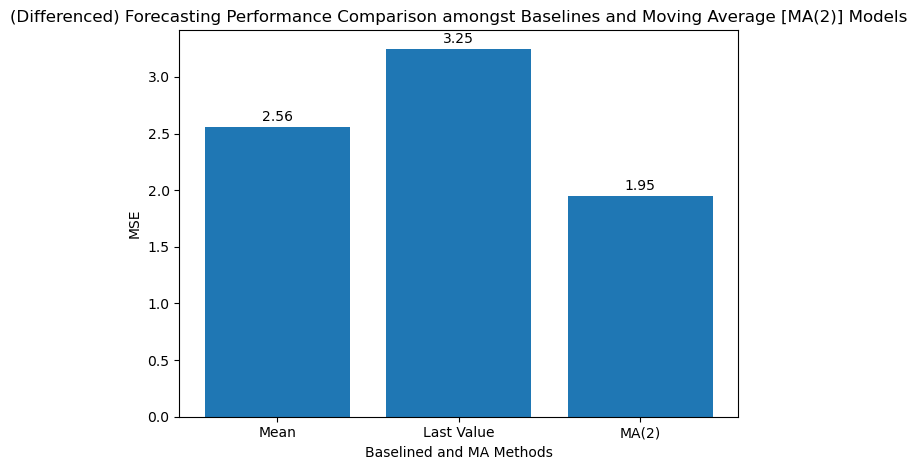

In [44]:
# Visualizes the differenced forecasting performance between all the used methods

x = ['Mean', 'Last Value', 'MA(2)']
y = [mse_mean, mse_last, mse_MA]

plt.bar(x, y)
plt.xlabel('Baselined and MA Methods')
plt.ylabel('MSE')

for idx, val in enumerate(y):
    plt.text(x=idx, y=val+0.05, s=round(val, 2), ha="center")
    
plt.title("(Differenced) Forecasting Performance Comparison amongst Baselines and Moving Average [MA(2)] Models")

plt.tight_layout()
plt.show()

Once best forecasts for the stationary process are obtained, the forecasts are inverse-transformed (meaning undoing the process of differencing) to bring the forecasts back to their original scale.

In [46]:
# Checks for the actual sales volume at timestep 450 - the first timestep in the horizon to forecast for
sales["widget_sales"].iloc[450]

64.7360049885278

In [47]:
# To inversed-transform, the cumulative sum of differenced forecasts gets added to
# actual sales volume at timesteps 450
sales_predictions = sales["widget_sales"].iloc[450] + predictions_diff["prediction_MA"].cumsum()

In [48]:
# prints forecasting for first few timesteps [starting from 450]
print(sales_predictions[:10])

450    63.657172
451    63.383863
452    64.165086
453    64.400055
454    64.569050
455    64.684860
456    63.889194
457    63.697908
458    62.775084
459    62.521024
Name: prediction_MA, dtype: float64


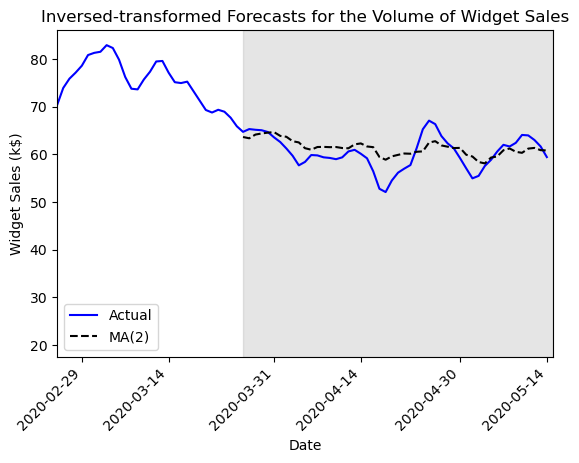

In [49]:
# Visualizes our inversed-transformed (untransformed) predictions against the target (original) data.

fig, ax = plt.subplots()
ax.plot(sales['date'], sales['widget_sales'], "b-", label="Actual") 
ax.plot(sales_predictions, "k--", label="MA(2)") 

ax.set_xlabel('Date')
ax.set_ylabel('Widget Sales (k$)') 
ax.xaxis.set_major_locator(AutoDateLocator())
ax.set_xlim(420, 500)
ax.axvspan(450, 500, color='#808080', alpha=0.2)
ax.legend()
ax.set_title("Inversed-transformed Forecasts for the Volume of Widget Sales")
fig.autofmt_xdate(rotation=45)
plt.show()

In [50]:
rmse_MA = root_mean_squared_error(sales["widget_sales"].iloc[450:], sales_predictions)
mae_MA = mean_absolute_error(sales["widget_sales"].iloc[450:], sales_predictions)

print(f"RMSE: {rmse_MA.round(2)}")
print(f"MAE: {mae_MA.round(2)}")

RMSE: 2.83
MAE: 2.32


### Observations

_Record all your observations related to this experiments._